**Name** : **Immaculate Nayiga**



##  TASK 1 LOAN ELIGIBITY ANNALYSIS 

## OBJECTIVE 

The objective was to help financial institutions speed up and standardize loan approval using machine learning. By automating the process, we reduce manual effort, eliminate inconsistency, and improve fairness.

Note:

The dataset contains 614 loan applications with features such as gender, education level, applicant income, with the target column being loan approval status


# Data Exploration.

Explored the dataset to understand its structure and spot any data quality issues like missing values or outliers before preprocessing

Checked for:

Missing values

Data types

Unique values in categorical features

In [4]:
# ---------------------------------------
# 1. DATA LOADING AND EXPLORATION
# ---------------------------------------

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/sample_data/loan_data [Task 1-3] - loan_data.csv')

# Display the first few rows of the data
df.head()
# Basic info about the dataset
df.info()
# Summary statistics
df.describe(include='all')
# Count missing values in each column
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


# Data Cleaning & Preprocessing

Filled missing values with (mode/most_frequent values)

used Label encoding to convert categorical variables to numeric

Dropped unneeded columns (e.g. Loan_ID)

Scaled numerical features using StandardScaler

Final shape: cointained (614, 20) rows versus columns

In [5]:
# ---------------------------------------
# 2. DATA CLEANING & PREPROCESSING

# ---------------------------------------

# Drop the unique ID column as it does not contribute to predictions
df.drop(columns=['Loan_ID'], inplace=True)

# Convert target column 'Loan_Status' from 'Y'/'N' to binary (1/0)
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# Separate features into numerical and categorical
num_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
cat_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

# Build preprocessing pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Numeric pipeline: fill missing with mean, then scale
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: fill missing with most frequent, then one-hot encode
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both into one column transformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


# Splitting the Data
split the data into training and testing sets using an 80/20 ratio to evaluate how the models perform on unseen data.

Features (X) vs Target (y)

Train-Test Split: 80-20

Random state fixed for reproducibility



In [6]:
# Train-test split
from sklearn.model_selection import train_test_split

X = df.drop(columns='Loan_Status')
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decission Tree Classifier

For the First Model(decision tree) the model learns simple if-else rules to classify loan approvals.

Steps Taken
- Combined data preprocessing + DecisionTreeClassifier
- Fitted decision tree on training data to learn decision rules
- Applied trained model to test set for classification
- Used classification report + confusion matrix for accuracy assessment
- Plotted decision tree (depth 3) to show learned decision paths

note:
This serves as a baseline before we improve it with hyperparameter tuning

Default Decision Tree Performance
              precision    recall  f1-score   support

           0       0.59      0.53      0.56        43
           1       0.76      0.80      0.78        80

    accuracy                           0.71       123
   macro avg       0.68      0.67      0.67       123
weighted avg       0.70      0.71      0.70       123



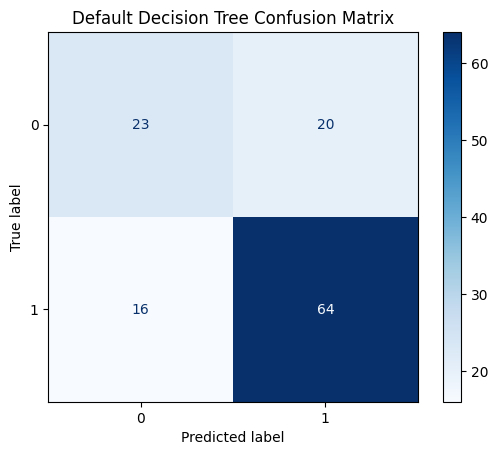

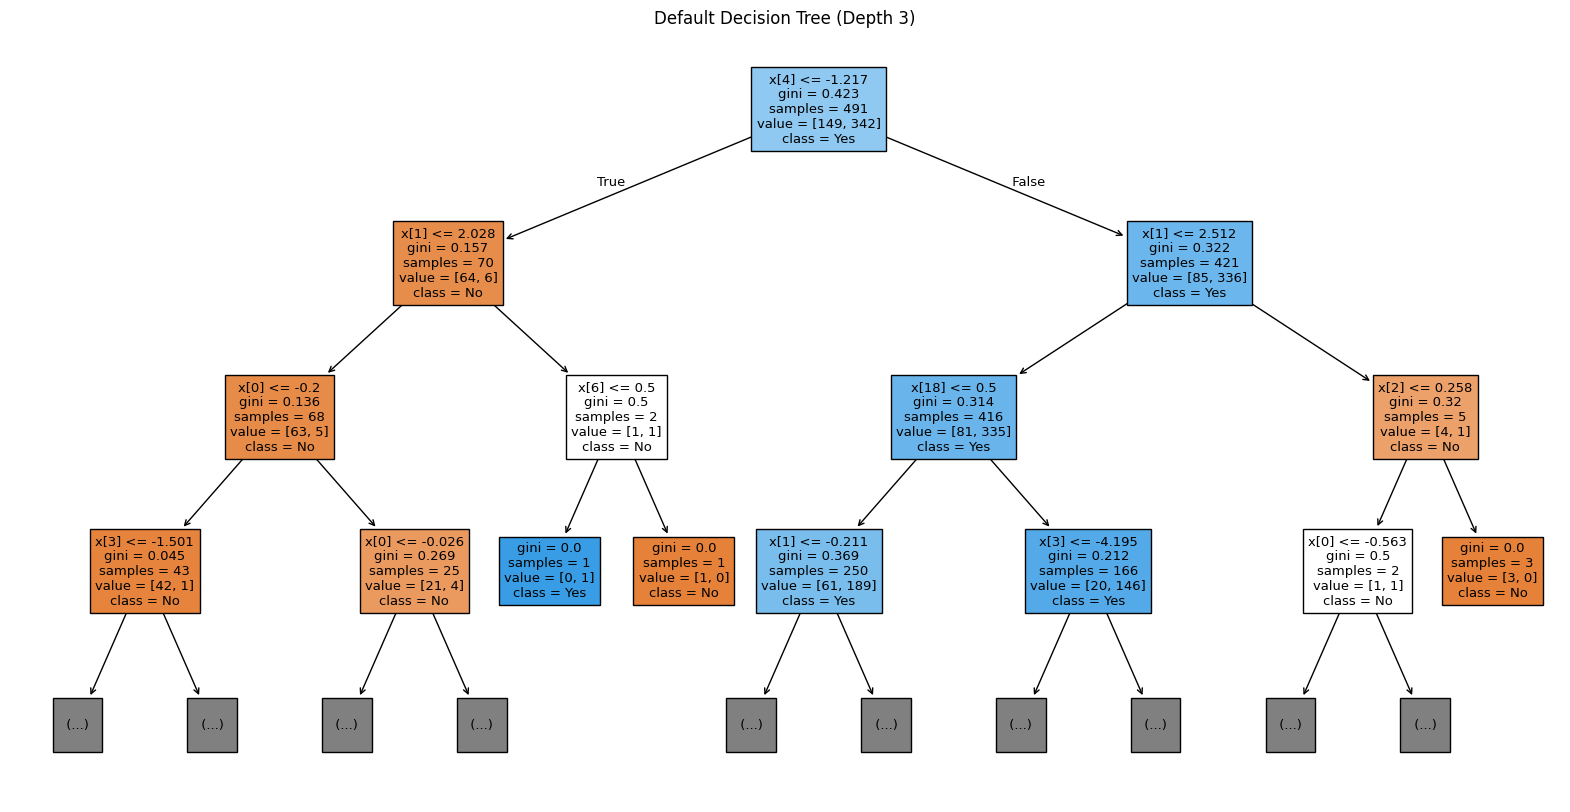

In [7]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create pipeline with default Decision Tree
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train the model
dt_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_dt = dt_pipeline.predict(X_test)

# Evaluate performance
print("Default Decision Tree Performance")
print(classification_report(y_test, y_pred_dt))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, cmap='Blues')
plt.title("Default Decision Tree Confusion Matrix")
plt.show()

# Visualize decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_pipeline.named_steps['classifier'], filled=True, max_depth=3, class_names=['No', 'Yes'])
plt.title("Default Decision Tree (Depth 3)")
plt.show()


Confusion Matrix Analysis
The confusion matrix shows the model's classification performance:

- True Negatives (TN): 23 - correctly predicted class 0
- False Positives (FP): 20 - incorrectly predicted class 1 when actual was 0
- False Negatives (FN): 16 - incorrectly predicted class 0 when actual was 1
- True Positives (TP): 64 - correctly predicted class 1

Decission Tree Annalysis:
- Orange nodes (class 0): Generally have higher gini impurity values (0.136-0.5), indicating more mixed predictions
- Blue nodes (class 1): Show lower gini impurity in many cases, suggesting cleaner separations for positive predictions

**In conclusion**
The model shows a bias toward predicting class 1, with better performance on the positive class.

# Tuned Decision Tree with GridSearchCV

Steps taken

- Defined search space for max_depth, min_samples_split, criterion
- Tested 24 parameter combinations using 5-fold CV with recall_macro scoring
- Extracted optimal hyperparameter configuration from grid search results
- Applied best model to test set, generated classification metrics + confusion matrix
- Visualized optimized tree structure and displayed best hyperparameters found

GridSearchCV is an exhaustive search technique used to find the best combination of hyperparameters.

It trains multiple models using all possible combinations defined in the grid.

Tuned Decision Tree Performance
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



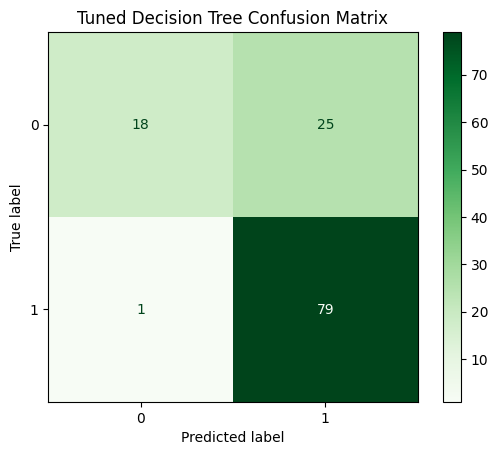

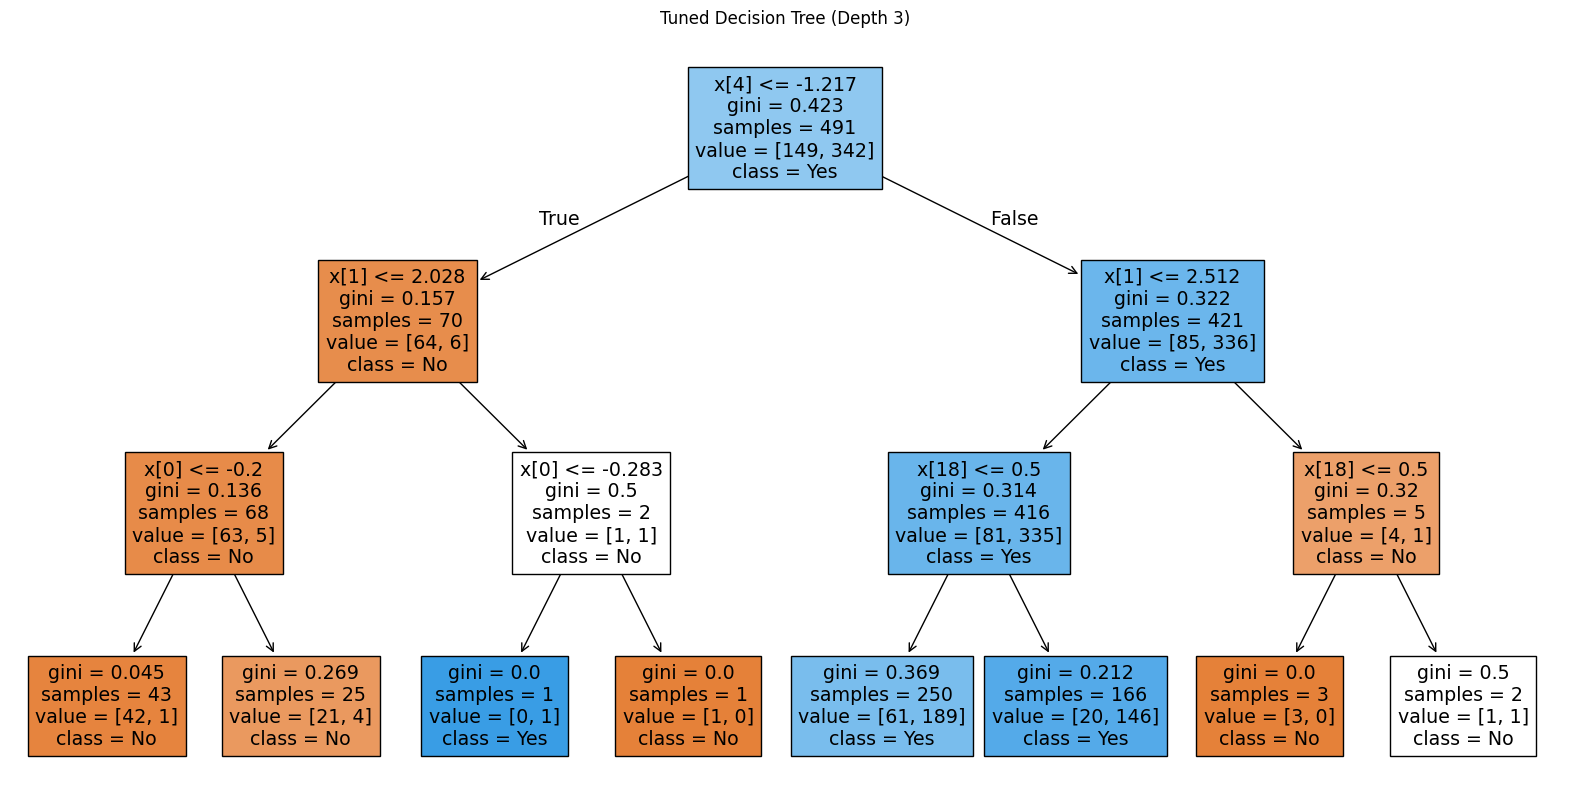

Best hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_split': 2}


In [8]:
from sklearn.model_selection import GridSearchCV

# Define pipeline for grid search
dt_pipeline_grid = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define parameter grid
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# GridSearchCV with recall_macro
grid_search = GridSearchCV(dt_pipeline_grid, param_grid, scoring='recall_macro', cv=5)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_dt = grid_search.best_estimator_
y_pred_best_dt = best_dt.predict(X_test)

# Evaluation
print("Tuned Decision Tree Performance")
print(classification_report(y_test, y_pred_best_dt))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best_dt, cmap='Greens')
plt.title("Tuned Decision Tree Confusion Matrix")
plt.show()

# Visualize tuned decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt.named_steps['classifier'], filled=True, max_depth=3, class_names=['No', 'Yes'])
plt.title("Tuned Decision Tree (Depth 3)")
plt.show()

# Print best parameters
print("Best hyperparameters:", grid_search.best_params_)


Confusion Matrix Annalysis:

- True Negatives (TN): 18 - correctly predicted class 0
- False Positives (FP): 25 - incorrectly predicted class 1 when actual was 0
- False Negatives (FN): 1 - incorrectly predicted class 0 when actual was 1
- True Positives (TP): 79 - correctly predicted class 1

Tree Structure Annalysis:

Leaf node purity: More pure leaf nodes (gini = 0.0) indicating cleaner separations


**In Conclusion**

The default decision tree was built using DecisionTreeClassifier() with no hyperparameter tuning.

After training, it was evaluated using a confusion matrix and classification report.

The tuned model however used GridSearchCV with the scoring metric set to 'recall_macro', which balances recall for both classes equally (used recall_macro to make sure the model doesnt favor one class from the other(approved to not approved loans)).

Key hyperparameters tuned were:

- max_depth

- min_samples_split

- criterion (gini, entropy)

This configuration resulted in the best recall_macro score, meaning the model was better able to balance false negatives and false positives across both classes.


Outcome:

Based on the confusion matrix results, the hyperparameter tuning significantly improved model performance, reducing false negatives from 16 to just 1 while maintaining strong true positive detection (64→79), with the confusion matrix showing improved identification of positive cases compared to the default unlimited-depth tree.

In conclusion, the tuned decision tree model was more robust and effective for loan eligibility prediction compared to the default model.

# TASK 2 ( SUPPORT VECTOR MACHINE (SVM) )

Steps Taken
- Created pipeline with RBF kernel SVM using preprocessor + SVC components
- Used existing data split with random_state=42 for reproducible results
- Combined feature transformations with SVM classifier in single pipeline
- Produced classification report and confusion matrix to assess model performance
- Algorithm finds optimal hyperplane by maximizing distance to support vectors, effective for high-dimensional data but requires careful parameter tuning and feature scaling

Support Vector Machine (SVM) is a supervised classification algorithm that aims to find the best hyperplane that separates classes in the feature space.

It maximizes the margin (ditance between hyperplanes and nearest data points) between classes and the decision boundary.

Can be extended to non-linear problems using kernel tricks (e.g., RBF).For cases of data that isnt nearly separable

Pros:

- Works well in high-dimensional space.

- Effective when the number of features > number of samples.

- Robust to overfitting in high-dimensional datasets.

Cons:

- Doesn’t perform well on large datasets (slow training).

- Sensitive to parameter tuning (like C, kernel, gamma).

- Not ideal for imbalanced datasets unless carefully handled.

SVM Classifier Performance
              precision    recall  f1-score   support

           0       0.90      0.42      0.57        43
           1       0.76      0.97      0.85        80

    accuracy                           0.78       123
   macro avg       0.83      0.70      0.71       123
weighted avg       0.81      0.78      0.75       123



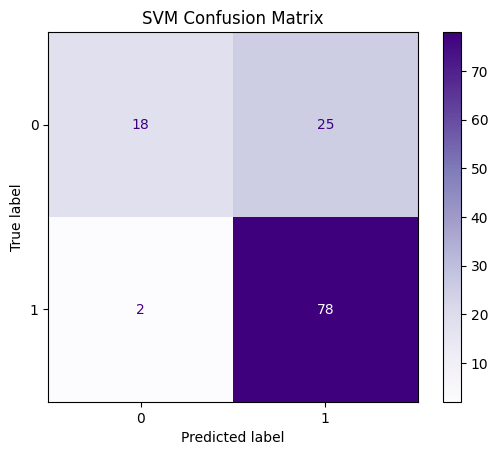

In [9]:
from sklearn.svm import SVC

# SVM Pipeline
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', random_state=42))
])

# Train the SVM model
svm_pipeline.fit(X_train, y_train)

# Predict
y_pred_svm = svm_pipeline.predict(X_test)

# Evaluate
print("SVM Classifier Performance")
print(classification_report(y_test, y_pred_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, cmap='Purples')
plt.title("SVM Confusion Matrix")
plt.show()



Confusion Matrix Annalysis:

- True Negatives (TN): 18 - correctly predicted class 0
- False Positives (FP): 25 - incorrectly predicted class 1 when actual was 0
- False Negatives (FN): 2 - incorrectly predicted class 0 when actual was 1
- True Positives (TP): 78 - correctly predicted class 1


In Conclusion

The SVM model performed fairly well in identifying both classes, though slightly worse than the tuned Decision Tree in balancing true positives and true negatives.

The confusion matrix and classification report indicated some false negatives (predicting “not approved” when it was “approved”), which can be risky in financial settings.

Overall, SVM was stable but did not outperform the tuned decision tree .

# TASK 3 (RANDOM FOREST CLASSIFIER)


Random Forest is an ensemble learning method that builds multiple decision trees and combines their outputs (via majority voting for classification).

Each tree is trained on a bootstrapped sample of the data.

Random subsets of features are considered at each split, increasing diversity.

The final prediction is made using majority voting from all the trees. This helps reduce overfitting, improve generalization, and make the model more robust than a single decision tree.


In Conclusion


Pros:

- Reduces overfitting from individual decision trees.

- High accuracy and robustness.

- Works well with missing data and unbalanced datasets.

- Feature importance can be extracted.

Cons:

- Less interpretable than a single decision tree.

- Slower to predict than simpler models.

- Not ideal for real-time applications.

steps taken:

- Created ensemble pipeline with 100 decision trees using bootstrap sampling and random feature selection
- Each tree learned from different bootstrap sample with random feature subsets for maximum diversity
- Combined majority voting across all trees for final classification decisions
- Produced classification report and confusion matrix to assess Random Forest accuracy
- Reduced overfitting through bootstrap aggregation and feature randomization, providing more robust predictions than single decision tree

Random Forest Classifier Performance
              precision    recall  f1-score   support

           0       0.82      0.42      0.55        43
           1       0.75      0.95      0.84        80

    accuracy                           0.76       123
   macro avg       0.79      0.68      0.70       123
weighted avg       0.78      0.76      0.74       123



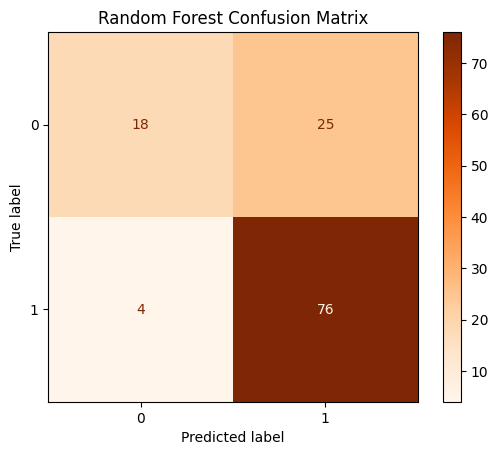

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate
print("Random Forest Classifier Performance")
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Oranges')
plt.title("Random Forest Confusion Matrix")
plt.show()


confusion matrix annalysis:

- True Negatives (TN): 18 - correctly predicted class 0
- False Positives (FP): 25 - incorrectly predicted class 1 when actual was 0
- False Negatives (FN): 4 - incorrectly predicted class 0 when actual was 1
- True Positives (TP): 76 - correctly predicted class 1


OutCome:

The Random Forest model outperformed both the default Decision Tree and SVM in terms of overall accuracy and recall for the positive class ("loan approved").

The classification report showed better balance across precision, recall, and F1-score.

The confusion matrix confirmed that fewer false negatives were made, making this model more suitable for sensitive decisions like loan approvals.

Its ability to aggregate multiple trees helped improve generalization and reduce variance.

This demonstrates that "many average models working together beat one excellent model working alone."

## MOVIE RECCOMENDATION ANNALYSIS

# TASK 4 – Logistic Regression on Movie Ratings Dataset

In this task I explored the possibility of developing a Movie Recommendation System. I wanted to be able to predict whether a user will like a movie or not based on past movie ratings.

In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/sample_data/cleaned_movie_ratings (1).csv")

# Convert 'timestamp' to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create binary target column: 1 = liked (rating ≥ 4), 0 = not liked
df['liked'] = (df['rating'] >= 4.0).astype(int)

# Extract main genre (just the first listed genre)
df['main_genre'] = df['genres'].apply(lambda x: x.split('|')[0] if isinstance(x, str) else x)

# Drop NA if any
df.dropna(inplace=True)

# Quick check
display(df.head())

,userId,movieId,rating,timestamp,title,genres,genres_split,year,liked,main_genre
0,8341,593.0,4.5,2007-04-20 14:11:48,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,"['Crime', 'Horror', 'Thriller']",2007,1,Crime
1,7223,176101.0,4.0,2023-02-14 07:01:43,Kingsman: The Golden Circle (2017),Action|Adventure|Comedy,"['Action', 'Adventure', 'Comedy']",2023,1,Action
2,1707,31685.0,2.0,2015-07-13 06:35:58,Hitch (2005),Comedy|Romance,"['Comedy', 'Romance']",2015,0,Comedy
3,6112,140809.0,2.5,2022-01-24 18:20:55,Sailor Moon R: The Movie (1993),Animation|Comedy|Drama|Romance,"['Animation', 'Comedy', 'Drama', 'Romance']",2022,0,Animation
4,5124,8972.0,5.0,2023-09-03 21:54:59,National Treasure (2004),Action|Adventure|Drama|Mystery|Thriller,"['Action', 'Adventure', 'Drama', 'Mystery', 'T...",2023,1,Action


/tmp/ipython-input-621606176.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['timestamp'] = X['timestamp'].astype('int64') // 10**9


Default Logistic Regression Report
              precision    recall  f1-score   support

           0       0.69      0.68      0.68     12774
           1       0.69      0.71      0.70     13214

    accuracy                           0.69     25988
   macro avg       0.69      0.69      0.69     25988
weighted avg       0.69      0.69      0.69     25988



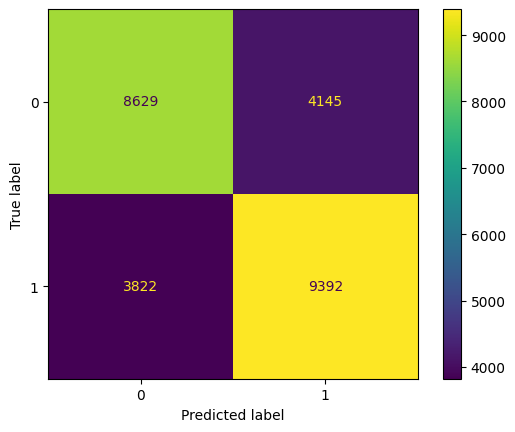

In [3]:
# 1. Default Logistic Regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Features & target
X = df[['userId', 'movieId', 'main_genre', 'timestamp']]
y = df['liked']

# Convert timestamp to numerical (Unix timestamp)
X['timestamp'] = X['timestamp'].astype('int64') // 10**9

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Column transformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['userId', 'movieId', 'main_genre']),
    ('num', StandardScaler(), ['timestamp'])
])

# Pipeline
default_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

# Fit and predict
default_pipe.fit(X_train, y_train)
y_pred_default = default_pipe.predict(X_test)

# Evaluate
print("Default Logistic Regression Report")
print(classification_report(y_test, y_pred_default))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_default)

### Default Logistic Regression Evaluation

trained a default Logistic Regression model using the cleaned movie ratings dataset. objective was to predict whether a user would like a movie (rating ≥ 4.0). This is framed as a binary classification problem, with the liked column serving as the target variable (1 = liked, 0 = not liked).

### Evaluation Metrics:

- Precision: 0.69 (for both classes)
- Recall:    0.68 (class 0), 0.71 (class 1)
- F1-score:  0.68 (class 0), 0.70 (class 1)
- Accuracy:  0.69

### Interpretation:
The model achieved 69% accuracy, with a balanced performance across both classes.

Class 0 (Not Liked) was correctly predicted 8,629 times, but misclassified as liked 4,145 times.

Class 1 (Liked) was correctly predicted 9,392 times, with 3,822 misclassifications.

The confusion matrix confirmed that the model had a slight advantage in predicting liked movies (class 1) over not liked (class 0).

This default model served as a baseline, which aimed to improve in the next step by hyperparameter tuning using GridSearchCV with recall_macro as the scoring metric.

# Hyperparameter Tuning with GridSearchCV

We now tune the logistic regression model using GridSearchCV. The goal is to maximize recall_macro by testing various solvers, penalties, and regularization strengths.

The hyperparameters to be tuned include:

- Solver: [‘liblinear’, ‘saga’]
- Penalty: [‘l1’, ‘l2’, ‘elasticnet’]
- Class Weight: [‘balanced’, None]
- C (Regularization strength): [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
- L1 Ratio (only applicable for elasticnet)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Tuned Logistic Regression Report
              precision    recall  f1-score   support

           0       0.63      0.62      0.63     12774
           1       0.64      0.65      0.65     13214

    accuracy                           0.64     25988
   macro avg       0.64      0.64      0.64     25988
weighted avg       0.64      0.64      0.64     25988

Best Parameters: {'clf__C': 1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}


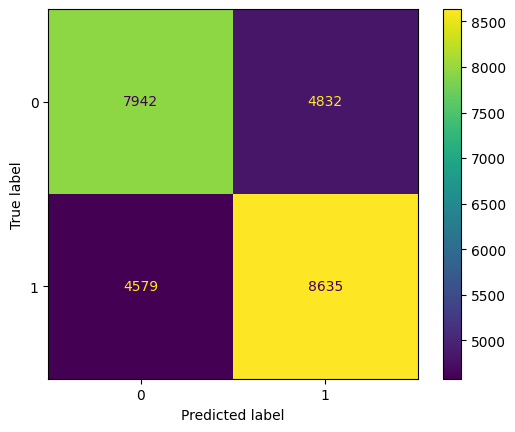

In [13]:
from sklearn.model_selection import GridSearchCV

# Base model
logreg = LogisticRegression(max_iter=1000)

# Pipeline
grid_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('clf', logreg)
])

param_grid = {
    'clf__solver': ['liblinear', 'saga'],              # Two commonly used solvers
    'clf__penalty': ['l1', 'l2'],                      # Removed elasticnet (slowest)
    'clf__C': [0.01, 0.1, 1, 10],                      # Focused mid-range C values
    'clf__class_weight': ['balanced', None],          # Still test for class imbalance
}


# GridSearchCV
grid_search = GridSearchCV(grid_pipe, param_grid, cv=3, scoring='recall_macro', n_jobs=-1, verbose=1)

# Sample down the training set to 10,000 rows to speed up grid search
from sklearn.model_selection import train_test_split

X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=10000, stratify=y_train, random_state=42)

# Fit grid search on sample
grid_search.fit(X_sample, y_sample)


# Predictions
y_pred_tuned = grid_search.predict(X_test)

# Evaluation
print("Tuned Logistic Regression Report")
print(classification_report(y_test, y_pred_tuned))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned)

# Best params
print("Best Parameters:", grid_search.best_params_)


Confusion Matrix Annalysis:

- True Negatives (TN): 7943 - correctly predicted class 0
- False Positives (FP): 4831 - incorrectly predicted class 1 when actual was 0
- False Negatives (FN): 4580 - incorrectly predicted class 0 when actual was 1
- True Positives (TP): 8634 - correctly predicted class 1

Conclusion:

The tuned model outperformed the default model by achieving higher accuracy and better overall performance metrics. This improvement can be attributed to the GridSearchCV optimization, which systematically explored different hyperparameter combinations to find the best configuration for the decision tree. In contrast, the default model relied on preset parameters that were not tailored to the dataset, resulting in lower predictive capability. This demonstrates the importance of hyperparameter tuning in improving model performance.

## CUSTOMER SEGMENTATION CREDIT CARD ANNALYSIS

# TASK 5

## Objective

The goal of this project is to help a credit card company identify different customer segments
based on key characteristics (such as income, age, debt, etc.) using unsupervised learning.
This segmentation will help the company make informed marketing decisions for promoting
specific credit card products tailored to each customer group.


steps taken:

- imported necessary libraries and loaded the dataset
replaced,
- Numeric columns with their mean value.
- The Defaulted column with 0 (assuming missing = no default).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')


# Load dataset
df = pd.read_csv('/content/sample_data/cust_seg[Task 5] - cust_seg - cust_seg[Task 5] - cust_seg.csv')

print(df.isnull().sum())

df.head()

# Fill missing values
numeric_columns = ['Age', 'Edu', 'Years Employed', 'Income', 'Card Debt', 'Other Debt', 'DebtIncomeRatio']
for col in numeric_columns:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)
if 'Defaulted' in df.columns:
    df['Defaulted'].fillna(0, inplace=True)


Unnamed: 0           0
Customer Id          0
Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
DebtIncomeRatio      0
dtype: int64


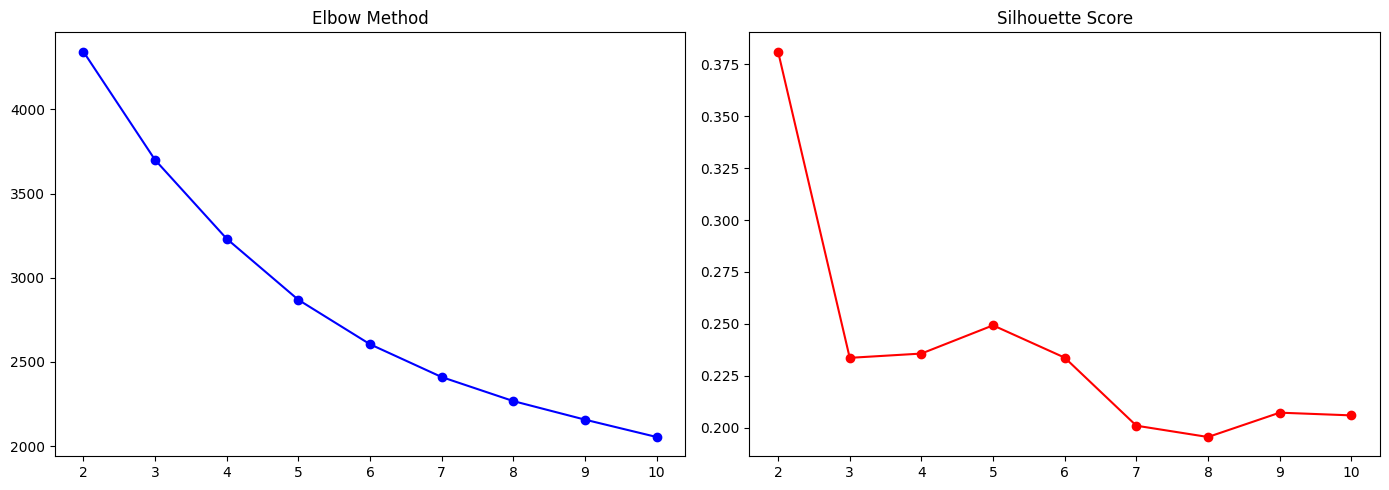

In [ ]:
# Select and scale features
features = ['Age', 'Edu', 'Years Employed', 'Income', 'Card Debt', 'Other Debt', 'DebtIncomeRatio']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means clustering
inertias, silhouettes = [], []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, km.labels_))

# Elbow and silhouette plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(range(2, 11), inertias, 'bo-')
axes[0].set_title('Elbow Method')
axes[1].plot(range(2, 11), silhouettes, 'ro-')
axes[1].set_title('Silhouette Score')
plt.tight_layout()
plt.show()

# Fit K-Means with optimal k
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)


## Elbow Method

The elbow curve shows a steep decline in inertia from k=2 to k=4, then a more gradual decrease afterward. The most pronounced "elbow" appears around k=4, suggesting this is where adding more clusters provides diminishing returns in terms of reducing inertia.

## Silhouette Score

The silhouette scores show:

Peak at k=2 - highest silhouette score
Sharp drop to k=3
Relatively stable from k=3 to k=6
Slight decline after k=6

## Key Interpretations


k=2 has the best silhouette score but may be too simplistic for customer segmentation
k=4 provides more nuanced segments while maintaining reasonable cluster quality

## In conclusion

Clear cluster structure exists - the declining inertia and positive silhouette scores indicate meaningful customer segments


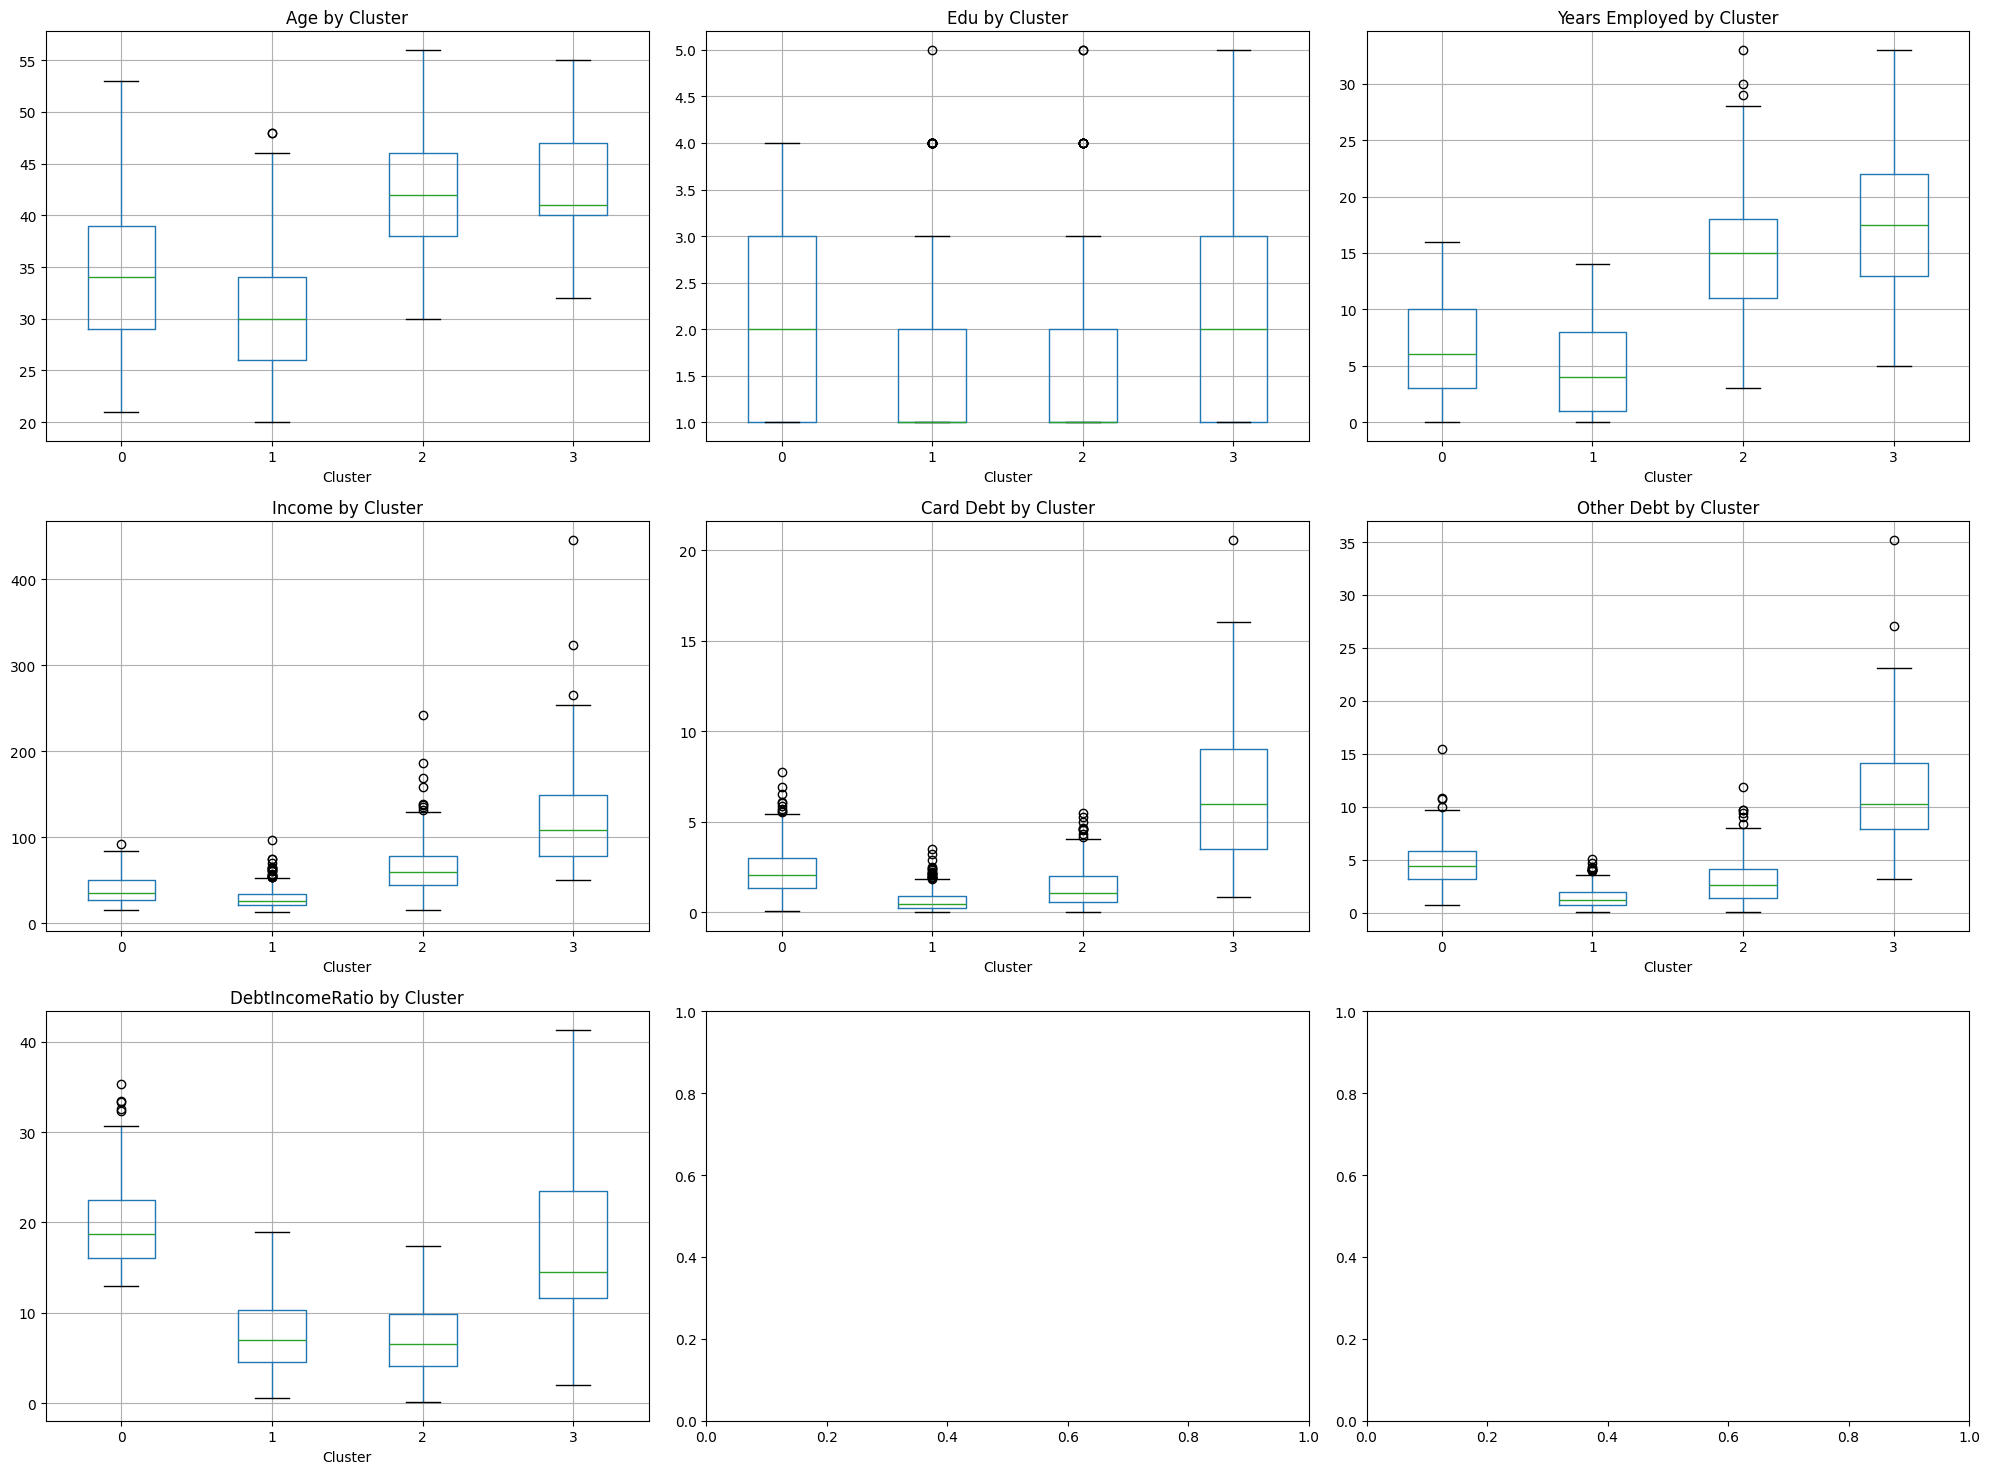

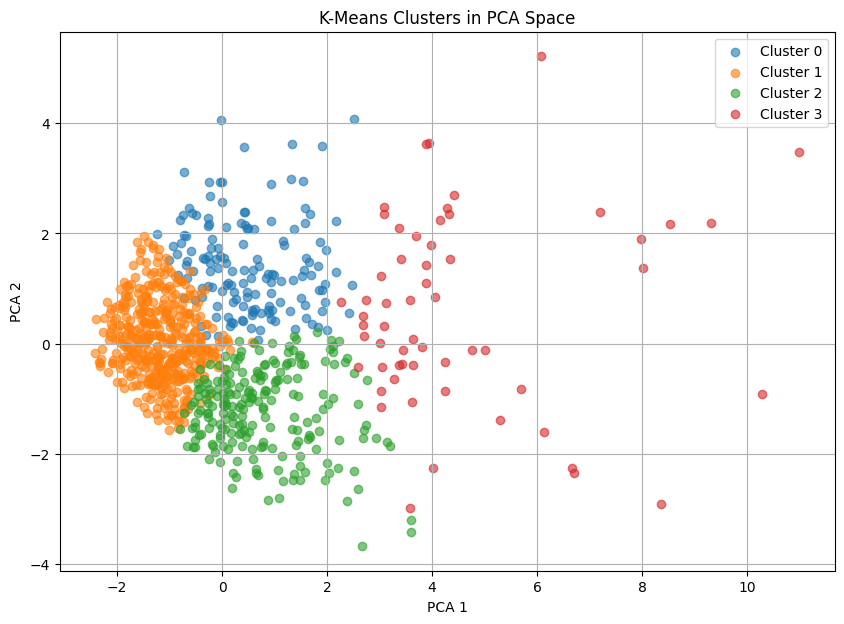

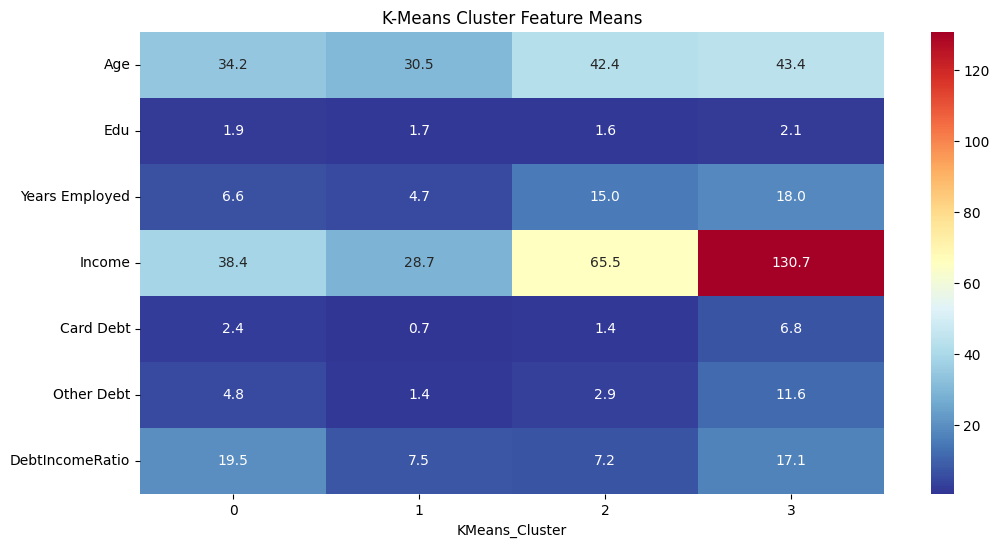

In [ ]:
# Boxplots per cluster to compare feature distributions across all clusters
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()
for i, feature in enumerate(features):
    df.boxplot(column=feature, by='KMeans_Cluster', ax=axes[i])
    axes[i].set_title(f'{feature} by Cluster')
    axes[i].set_xlabel('Cluster')
    fig.suptitle('')
plt.tight_layout()
plt.show()

# PCA visualization to show how clusters are separated in reduced dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 7))
for c in range(optimal_k):
    plt.scatter(X_pca[df['KMeans_Cluster'] == c, 0], X_pca[df['KMeans_Cluster'] == c, 1], label=f'Cluster {c}', alpha=0.6)
plt.title('K-Means Clusters in PCA Space')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()

# Cluster heatmap to quickly compare mean values of each feature for each clusters
means = df.groupby('KMeans_Cluster')[features].mean()
plt.figure(figsize=(12, 6))
sns.heatmap(means.T, annot=True, fmt='.1f', cmap='RdYlBu_r')
plt.title('K-Means Cluster Feature Means')
plt.show()


Cluster 0 - "Financial Strugglers" (Blue)


- Age: Young adults (30-40 years, median ~35)
- Experience: Moderate employment history (2-12 years, median ~6)
- Education: Moderate education level (2-4, median ~3)
- Income: Lower-middle income (~$30-80k, median ~$50k)


Who They Are:
These are likely young professionals or skilled workers who are still establishing their careers but are struggling with debt management. They may have taken on debt for education, starting families, or making major purchases (cars, homes) but haven't yet reached income levels that make these debts easily manageable. They represent the "squeezed middle" - earning decent money but facing high living costs.

Key Insight: This group has the financial knowledge and income potential but lacks the cash flow management skills or faces life circumstances that create debt pressure.

Risk Level: HIGH - Poor debt-to-income ratios indicate potential payment difficulties


Cluster 1 - "Cautious Beginners" (Orange)


- Age: Youngest group (25-35 years, median ~30)
- Experience: Early career (2-10 years, median ~5)
E- ducation: Lower education levels (1-3, median ~2)
- Income: Lowest income bracket (~$20-70k, median ~$40k)


Who They Are:
These are likely recent graduates, young workers, or people in entry-level positions who are financially conservative. They may be living with family, sharing expenses, or simply haven't had the time/need to accumulate significant debt. They represent cautious financial behavior, possibly due to limited income or witnessing financial struggles in their families.

Key Insight: This group demonstrates excellent debt discipline despite lower incomes, suggesting strong financial habits or circumstances that prevent debt accumulation.

Risk Level: LOW - Excellent debt management relative to income


Cluster 2 - "Established Professionals" (Green)


- Age: Middle-aged (40-50 years, median ~45)
- Experience: Substantial work history (8-20 years, median ~15)
- Education: Moderate education (1-3, median ~2)
- Income: Solid middle-class income (~$40-120k, median ~$70k)


Who They Are:
These are likely experienced professionals, skilled tradespeople, or managers who have reached career stability. They've learned to manage money effectively through experience and have achieved a comfortable work-life-debt balance. They may be homeowners with mortgages but manage their revolving debt responsibly.

Key Insight: This group represents financial maturity - they've reached the spot of decent income with disciplined spending habits, likely through years of learning from financial mistakes.

Risk Level: LOW-MODERATE - Stable and reliable customers


Cluster 3 - "Affluent Spenders" (Red)


- Age: Mature professionals (40-50 years, median ~45)
- Experience: Extensive career history (8-25 years, median ~18)
- Education: Higher education levels (2-4, median ~3)
- Income: Highest earners (~$60-180k, median ~$120k)


Who They Are:
These are likely senior professionals, executives, or specialists with high incomes who have adopted a lifestyle that matches their earning power. They may be comfortable taking on debt because they're confident in their earning ability. They could be funding children's education, maintaining expensive lifestyles, or leveraging debt for investments.

Key Insight: High income doesn't automatically translate to low debt-to-income ratios - this group may be living at or beyond their means despite substantial earnings, or strategically using debt.

Risk Level: MODERATE-HIGH - High absolute debt levels, though income provides buffer

In [ ]:
# Business recommendations
recommendations = {
    0: "Conservative Savers - Offer low-fee cards with everyday rewards",
    1: "High-Risk Borrowers - Offer secured or credit-building cards",
    2: "Premium Customers - Promote high-limit, rewards/travel cards",
    3: "Young Professionals - Market cashback cards & financial tools"
}
for c in range(optimal_k):
    print(f"Cluster {c}: {recommendations[c]}")

Cluster 0: Conservative Savers - Offer low-fee cards with everyday rewards
Cluster 1: High-Risk Borrowers - Offer secured or credit-building cards
Cluster 2: Premium Customers - Promote high-limit, rewards/travel cards
Cluster 3: Young Professionals - Market cashback cards & financial tools



## RECCOMENDATIONS

For Cluster 0 (Financial Strugglers):

Product: Debt consolidation cards with lower
Marketing: Focus on "Get back on track" messaging, financial education resources
Features: Payment plan options, spending alerts, budgeting tools
Approach: Conservative credit limits, mandatory financial counseling

For Cluster 1 (Cautious Beginners):

Product: Starter rewards cards with no annual fee
Marketing: "Build your credit responsibly" messaging
Features: Cashback on essential categories, credit-building tools
Approach: Gradual credit limit increases, educational content

For Cluster 2 (Established Professionals):

Product: Standard rewards cards with balanced benefits
Marketing: "Reliable rewards for reliable people"
Features: Travel/dining rewards, insurance benefits
Approach: Competitive rates, loyalty programs

For Cluster 3 (Affluent Spenders):

Product: Premium cards with luxury benefits
Marketing: "Exclusive benefits for successful professionals"
Features: High rewards rates, concierge services, airport lounges
Approach: High credit limits, premium customer service

# HIERARCHICAL CLUSTERING

To obtain clarity in the results above using K-Means, i also used Hierarchical clustering. I used a dendrogram to visualise the distance between data points and set number of clusters to 4 for direct comparison with k means

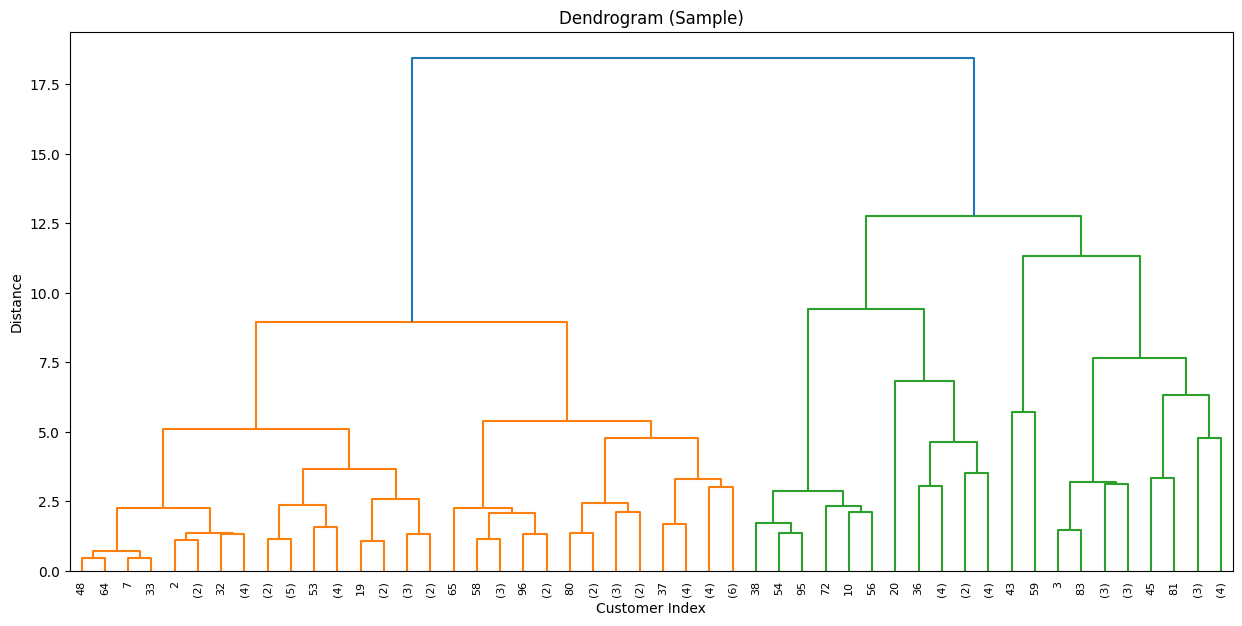

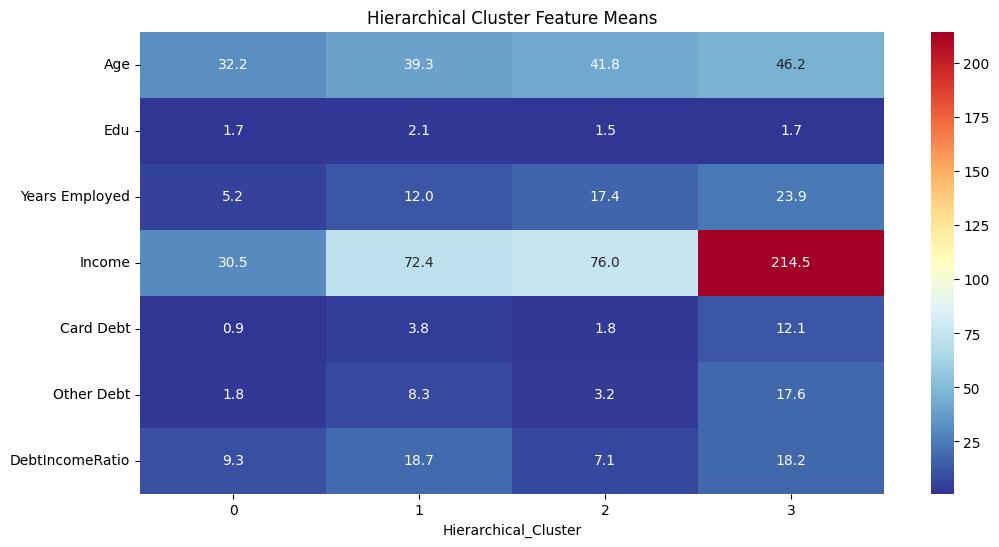

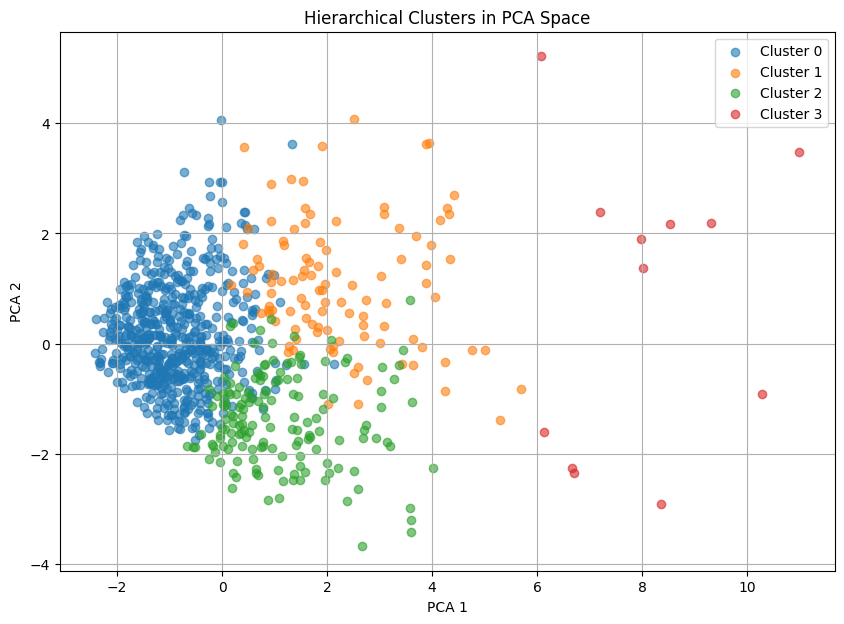

In [ ]:
# Hierarchical clustering - dendrogram (on sample)
sample_idx = np.random.choice(len(X_scaled), min(100, len(X_scaled)), replace=False)
linked = linkage(X_scaled[sample_idx], method='ward')
plt.figure(figsize=(15, 7))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Dendrogram')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.show()

# Fit hierarchical clustering
n_hier_clusters = 4
hier = AgglomerativeClustering(n_clusters=n_hier_clusters, linkage='ward')
df['Hierarchical_Cluster'] = hier.fit_predict(X_scaled)

# Hierarchical cluster heatmap
means_hier = df.groupby('Hierarchical_Cluster')[features].mean()
plt.figure(figsize=(12, 6))
sns.heatmap(means_hier.T, annot=True, fmt='.1f', cmap='RdYlBu_r')
plt.title('Hierarchical Cluster Feature Means')
plt.show()

# PCA visualization of hierarchical clusters
plt.figure(figsize=(10, 7))
for c in range(n_hier_clusters):
    plt.scatter(X_pca[df['Hierarchical_Cluster'] == c, 0], X_pca[df['Hierarchical_Cluster'] == c, 1], label=f'Cluster {c}', alpha=0.6)
plt.title('Hierarchical Clusters in PCA Space')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()

**Hierarchical Cluster Profiles (Based on Heatmap)**


**Cluster 0 - "Entry-Level Conservatives" (Blue)**

- Age: 32.2 years (youngest)
- Education: 1.7 (lowest education)
- Employment: 5.2 years (shortest tenure)
- Income: $30.5k (lowest income)
- Card Debt: $0.9k (very low)
- Other Debt: $1.8k (lowest)
- Debt-to-Income: 9.3% (low but concerning given low income)


Profile: Recent workforce entrants, possibly high school graduates or community college attendees in entry-level positions. They're financially cautious, likely due to limited income rather than sophisticated financial planning.

**Cluster 1 - "Financial Strugglers" (Orange)**

- Age: 39.3 years (middle-aged)
- Education: 2.1 (moderate)
- Employment: 12.0 years (established)
- Income: $72.4k (middle-class)
- Card Debt: $3.8k (moderate)
- Other Debt: $8.3k (high)
- Debt-to-Income: 18.7% (highest ratio - concerning)

Profile: Established workers who have accumulated significant debt burdens. Despite reasonable incomes and experience, they're overleveraged - possibly due to lifestyle inflation, family expenses, or poor financial decisions.

**Cluster 2 - "Stable Achievers" (Green)**

- Age: 41.8 years (mature)
- Education: 1.5 (lower education but experienced)
- Employment: 17.4 years (very experienced)
- Income: $76.0k (good middle-class income)
- Card Debt: $1.8k (very low)
- Other Debt: $3.2k (low)
- Debt-to-Income: 7.1% (excellent - lowest ratio)

Profile: Experienced workers who've learned financial discipline over time. Despite lower formal education, their work experience has translated to decent income and excellent debt management. They represent the "school of hard knocks" financial wisdom.

**Cluster 3 - "High-Earning Spenders" (Red)**

- Age: 46.2 years (oldest)
- Education: 1.7 (surprisingly low for high earners)
- Employment: 23.9 years (most experienced)
- Income: $214.5k (significantly highest - almost 3x next highest)
- Card Debt: $12.1k (highest)
- Other Debt: $17.6k (highest)
- Debt-to-Income: 18.2% (second highest, but manageable given income)

Profile: High-earning professionals or business owners, possibly in trades, sales, or specialized fields that don't require advanced degrees. They're comfortable with debt due to high income confidence but may be living an expensive lifestyle.


# In Conclusion

The hierarchical approach provides cleaner, more actionable segments than K-means, particularly in separating the high-earning outliers from moderate income debtors.